# Analysis of Real Data from the PDHD Detector

Once you're comfortable with the simplified MC data, the next step is to analyze real data collected by the ProtoDUNE Horizontal Drift (PDHD) detector.

As a surface detector, PDHD is continuously bombarded by cosmic rays, resulting in multiple overlapping tracks within each recorded event. 

In [50]:
import uproot #Uproot is a Python library that allows you to read, write, and manipulate ROOT files without requiring ROOT or C++.
import awkward as ak #this is for ragged data handling, which is common in particle physics data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
# %matplotlib widget 
warnings.filterwarnings('ignore') # Ignore warnings for cleaner output

filepath = "../data/pdhd_run032974_tps.root"

with uproot.open(filepath) as file:
    tree = file["triggerana/tree"]  # Adjust the path if your tree is elsewhere
    print(tree.keys())  # This prints all branch names in the tree

['event', 'run', 'subrun', 'TP_channel', 'TP_startT', 'TP_peakT', 'TP_TOT', 'TP_SADC', 'TP_peakADC', 'TP_plane', 'TP_TPC']


In [51]:
#instead of using all the branches, we can specify which ones we want to read
def load_data(filepath, branch_names, max_events=3000):
    """Load data from a ROOT file into a pandas DataFrame."""
    try:
        with uproot.open(filepath) as file:
            tree = file["triggerana/tree"]
            arrays = tree.arrays(branch_names, library="ak", entry_stop=max_events)
            return ak.to_dataframe(arrays)
    except Exception as e:
        print(f"Error loading data from {filepath}: {e}")
        return None

# name of branches in the TTree to read into the pandas df
TP_BRANCHES_df = ['event', 'run', 'subrun', 'TP_channel', 'TP_startT', 'TP_peakT', 'TP_TOT', 'TP_SADC', 'TP_peakADC', 'TP_plane', 'TP_TPC'] #trigger primitives for real data
TP_BRANCHES = ["event", "TP_channel", "TP_startT", "TP_peakT", "TP_peakADC", "TP_SADC", "TP_TOT", "TP_plane", "TP_TPC",
               "TP_trueX", "TP_trueY", 'TP_trueZ', 'TP_signal'] #trigger primites for MC data

#MC-specific branches
MC_BRANCHES = ["event", "Eng", "Px", "Py", "Pz", "P"] #MC information from the particle

#--simulation data containing 100 single muon events in the ProtoDUNE Horizontal Drift Geometry (PDHD)
mc  = load_data("../data/muons_simtps_pdhd_n100.root", MC_BRANCHES, 1000) #MC carlo output 
tps  = load_data("../data/muons_simtps_pdhd_n100.root", TP_BRANCHES, 1000)  #corresponding trigger primitive (TP) information  

In [52]:
#Let's load the data from runs
df_32973= load_data("../data/pdhd_run032973_tps.root", TP_BRANCHES_df, 1000)
df_32974= load_data("../data/pdhd_run032974_tps.root", TP_BRANCHES_df, 1000)
df_32975= load_data("../data/pdhd_run032975_tps.root", TP_BRANCHES_df, 1000)

df_32973.run_name = "Cosmic run 32973"
df_32974.run_name = "Cosmic run 32974"
df_32975.run_name = "Cosmic run 32975"

# Concatenate all three datasets
df_all = pd.concat([df_32973, df_32974, df_32975], ignore_index=True)

In [54]:
df_32973.head()

event    run  subrun  TP_channel         TP_startT  \
entry subentry                                                       
0     0             8  32973       1         191  3385478745711861   
      1             8  32973       1         191  3385478745711992   
      2             8  32973       1         191  3385478745715486   
      3             8  32973       1         191  3385478745716060   
      4             8  32973       1         191  3385478745716754   

                        TP_peakT  TP_TOT  TP_SADC  TP_peakADC  TP_plane  \
entry subentry                                                            
0     0         3385478745711863       6     1933         579         0   
      1         3385478745711997       8      601          85         0   
      2         3385478745715489       6      542         109         0   
      3         3385478745716067      10     1990         307         0   
      4         3385478745716759       8      932         153         0   

                TP_TPC  
entry subentry          
0     0              0  
      1              0  
      2              0  
      3              0  
      4              0

In [55]:
#Let's see what event IDs exist in the file
triggers = df_32974.event.unique()
print(f"Event {triggers}")

Event [  8  16  24  32  40  48  56  64  72  80  88  96 104 112 120 128 136 144
 152 160 168 176 184 192 200 208 216 224 232 240 248 256 264 272 280 288
 296 304 360 368]


In [56]:
# Global variable for APA ranges
apa_ranges = {
    "APA1": (0, 2560),
    "APA3": (2560, 5120),
    "APA2": (5120, 7680),
    "APA4": (7680, 10240),
}

### Examine general distributions from cosmic signals from the full PDHD detector (single run). 

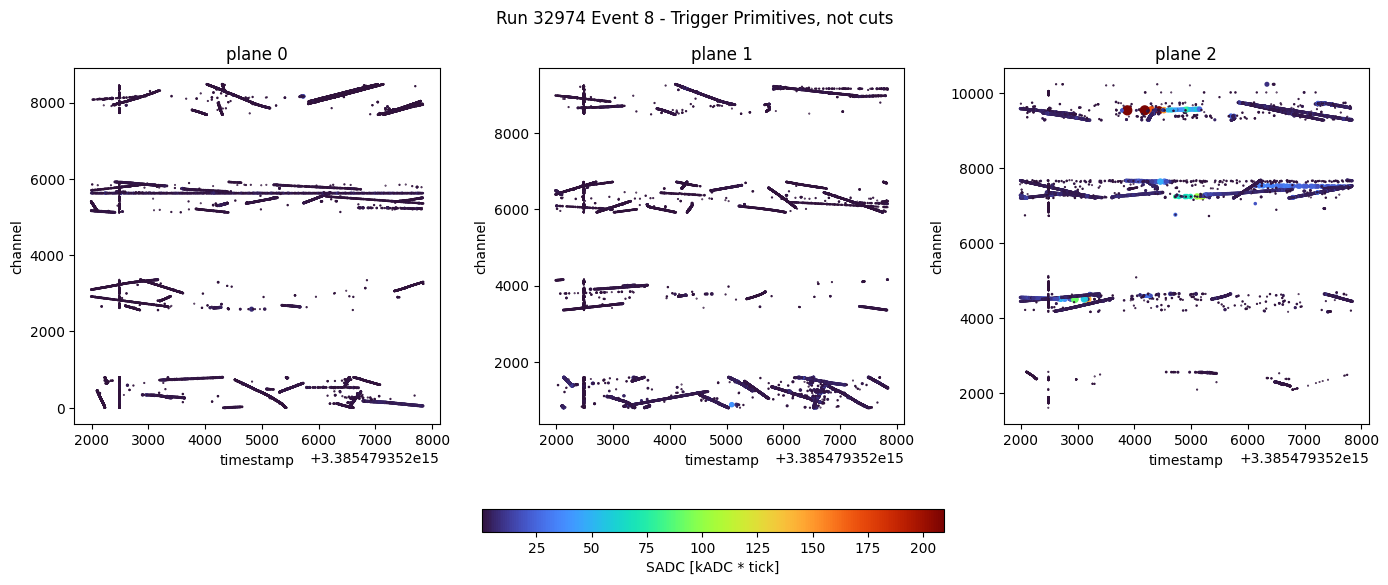

In [57]:
event = triggers[0] #single event
#timestamps correspond to microseconds, the big number is the first detection hit in timestamp

tps_32974 = df_32974[(df_32974.event == event) & (df_32974.TP_TOT > 1)]
vmin, vmax = tps_32974["TP_SADC"].min()/1e3, (tps_32974["TP_SADC"].max()/1e3)/2
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

for plane in range(3):
    tps = tps_32974[tps_32974.TP_plane == plane]
    sc = ax[plane].scatter(tps.TP_peakT, tps.TP_channel, s=tps.TP_TOT / 10, c=tps.TP_SADC/1e3, cmap='turbo', vmin=vmin, vmax=vmax)
    ax[plane].set_xlabel("timestamp")
    ax[plane].set_ylabel("channel")
    ax[plane].set_title(f"plane {plane}")   

fig.suptitle(f"Run {df_32974['run'].unique()[0]} Event {event} - Trigger Primitives, not cuts")
fig.colorbar(sc, ax=ax, orientation='horizontal', fraction=0.05, pad=-0.3).set_label("SADC [kADC * tick]")
plt.tight_layout()
plt.show()

Minimum value 0.132, maximum 209.2665, mean 2.3198971898283123, std deviation 5.5452637809506


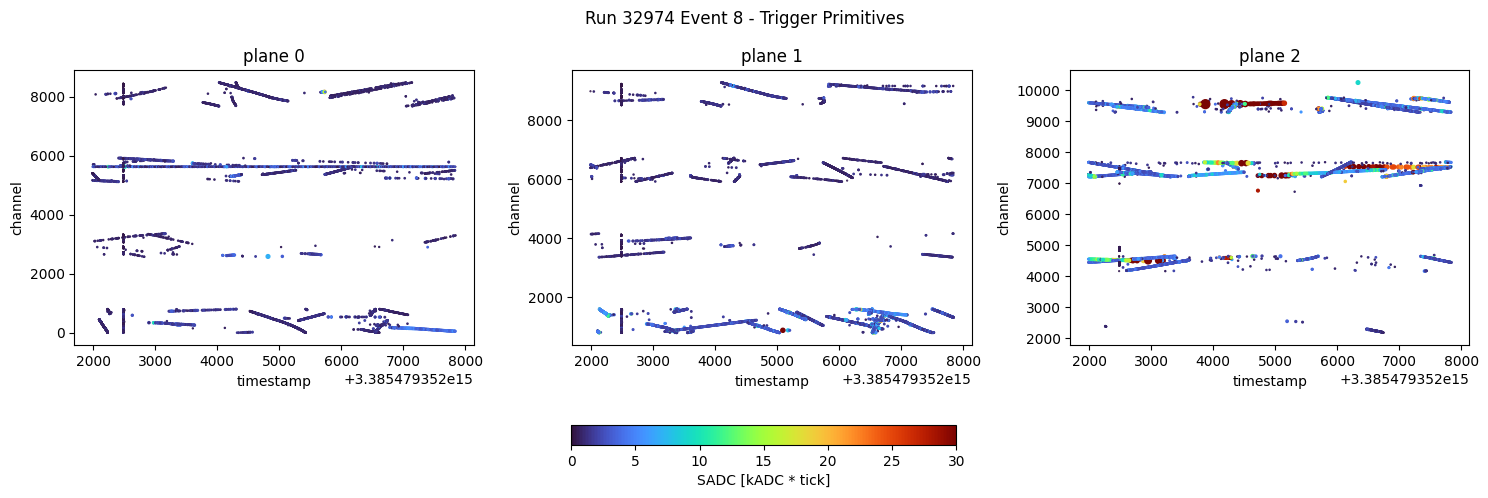

In [58]:
tps_32974 = df_32974[(df_32974.event == event) & (df_32974.TP_peakADC> 120)] #removing some noise from pileup
#vmin, vmax = tps_32974["TP_SADC"].min()/1e3, (tps_32974["TP_SADC"].max()/1e3)/2
print(f"Minimum value {tps_32974['TP_SADC'].min()/1e3}, maximum {(tps_32974['TP_SADC'].max()/1e3)/2}, mean {tps_32974['TP_SADC'].mean()/1e3}, std deviation {tps_32974['TP_SADC'].std()/1e3}")
vmin, vmax = (0, 30) #Low energy boundary

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for plane in range(3):
    tps = tps_32974[tps_32974.TP_plane == plane]
    sc = ax[plane].scatter(tps.TP_peakT, tps.TP_channel, s=tps.TP_TOT / 10, c=tps.TP_SADC/1e3, cmap='turbo', vmin=vmin, vmax=vmax)
    ax[plane].set_xlabel("timestamp")
    ax[plane].set_ylabel("channel")
    ax[plane].set_title(f"plane {plane}")

fig.suptitle(f"Run {df_32974['run'].unique()[0]} Event {event} - Trigger Primitives")
fig.colorbar(sc, ax=ax, orientation='horizontal', fraction=0.05, pad=-0.3).set_label("SADC [kADC * tick]")
plt.tight_layout()
plt.show()

- Induction planes appear to be noisier and have less SADC variations.
- Increased noise due to pile-up of simultaneous activity.
- More variable noise levels compared to MC simulations, and noisy/dead channels (which can change across multiple trigger records, as the data taking conditions are never exactly the same!)

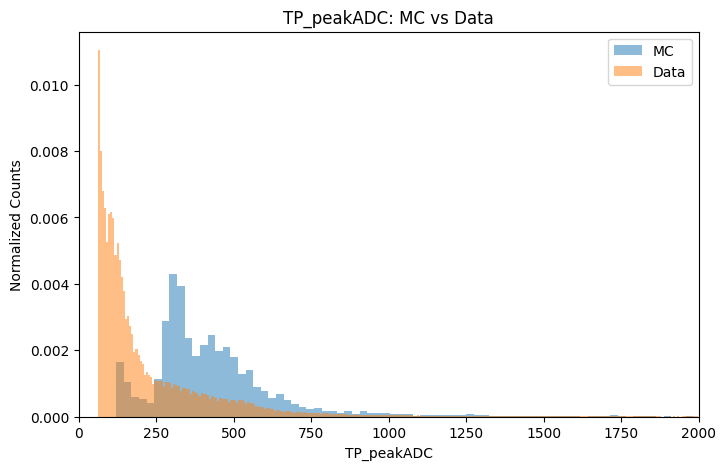

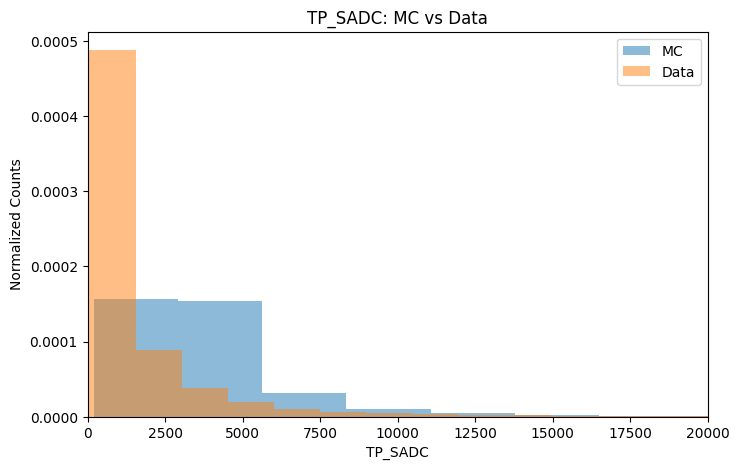

In [59]:
# Compare TP_peakADC distributions
plt.figure(figsize=(8,5))
plt.hist(tps['TP_peakADC'], bins=int(2*np.sqrt(len(tps))), alpha=0.5, label='MC', density=True)
plt.hist(df_32974['TP_peakADC'], bins=int(2*np.sqrt(len(df_32974))), alpha=0.5, label='Data', density=True)
plt.xlabel('TP_peakADC')
plt.ylabel('Normalized Counts')
plt.xlim(0, 2000)  # Set x-axis limit for better visibility
plt.legend()
plt.title('TP_peakADC: MC vs Data')
plt.show()

# Compare TP_SADC distributions
plt.figure(figsize=(8,5))
plt.hist(tps['TP_SADC'], bins=int(2*np.sqrt(len(tps))), alpha=0.5, label='MC', density=True)
plt.hist(df_32974['TP_SADC'], bins=int(2*np.sqrt(len(df_32974))), alpha=0.5, label='Data', density=True)
plt.xlabel('TP_SADC')
plt.ylabel('Normalized Counts')
plt.xlim(0, 20000)
plt.legend()
plt.title('TP_SADC: MC vs Data')
plt.show()

- Clearly a presence of peak at lower energy and lower thresholds (noisier data)

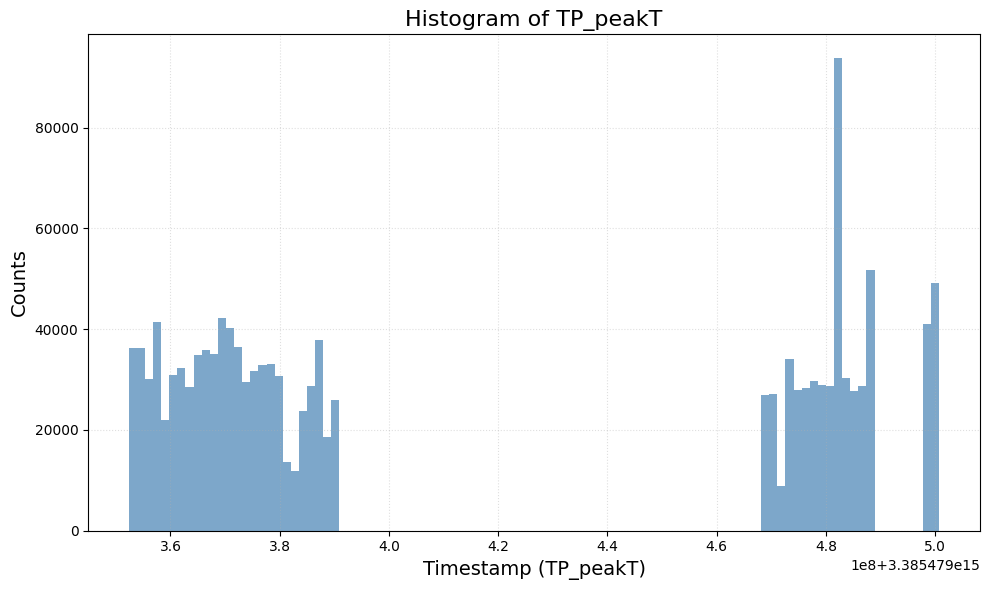

In [60]:
# Assuming df_32974 is already loaded in your notebook
plt.figure(figsize=(10,6))
plt.hist(df_32974["TP_peakT"], bins=100, color='steelblue', alpha=0.7)
plt.xlabel("Timestamp (TP_peakT)", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.title("Histogram of TP_peakT", fontsize=16)
plt.grid(True, linestyle="dotted", alpha=0.4)
plt.tight_layout()
plt.show()

### General look at the activity per APA 

1 μs (timestamp)	≈ 2 mm (drift distance)

In [61]:
def plot_TPC_activity(tp_df, thresh, vmin=None, vmax=None, show_counts=True):
    """
    Plots TP activity per APA, usually for multiple SADC thresholds in the thresholds array but it is optional.
    Pass a DataFrame containing all trigger primitives. Plots the Tp_peakT vs TP_channel for each APA: size proportional to TP_TOT and color proportional to TP_SADC.
    Also plots bar chart of TP counts per APA when show_counts is True (default).
    Title of the histogram is set to "TP Activity per APA" by default, but can be customized with the run_type parameter (usually set by user to "cosmic/beam + number of the run").
    """
    apa_ranges = {
        "APA1": (0, 2560),
        "APA3": (2560, 5120),
        "APA2": (5120, 7680),
        "APA4": (7680, 10240),
    }
    apa_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    title_prefix="TP Activity per APA"

    filtered = tp_df[tp_df.TP_peakADC > thresh]
    print(f"Threshold: {thresh} (TPs: {len(filtered)}, Retaining {len(filtered)/len(tp_df)*100:.2f}% of raw TP)")
    run_type = tp_df.run_name
    plot_title = f"{title_prefix} ({run_type}, threshold: {thresh:.0f} ADC)"

    # --- Scatter plots ---
    fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
    for i, (apa, (start, stop)) in enumerate(apa_ranges.items()):
        ax = axs[i//2][i%2]
        df_apa = filtered[(filtered.TP_channel >= start) & (filtered.TP_channel < stop)]
        sc = ax.scatter(
            df_apa.TP_peakT, df_apa.TP_channel,
            s=df_apa.TP_TOT / 10,
            c=df_apa.TP_SADC if thresh is not None else df_apa.TP_SADC / 1e3,
            cmap="turbo",
            alpha=0.7,
            edgecolor="none",
            vmin=vmin, vmax=vmax
        )
        ax.set_title(f"{apa} (channels {start}-{stop-1})")
        ax.set_xlabel("timestamp")
        ax.set_ylabel("TP_channel")
        ax.grid(True, linestyle="dotted", alpha=0.5)

    plt.suptitle(f"{plot_title}", fontsize=18)
    if thresh is not None:
        fig.colorbar(sc, ax=axs, orientation="vertical", shrink=0.8, label="TP SADC")
    plt.show()

    # --- Bar plot: TP count per APA ---
    if show_counts:
        apa_counts = [
            len(filtered[(filtered.TP_channel >= start) & (filtered.TP_channel < stop)])
            for (start, stop) in apa_ranges.values()
        ]
        plt.figure(figsize=(8, 5))
        plt.bar(apa_ranges.keys(), apa_counts, color=apa_colors)
        plt.ylabel("Number of TPs")
        plt.title(f"Total TP Count per APA ({'threshold: ' + str(thresh) if thresh is not None else 'no cut'})")
        plt.show()

Run 32973
Threshold: 100 (TPs: 587263, Retaining 75.75% of raw TP)


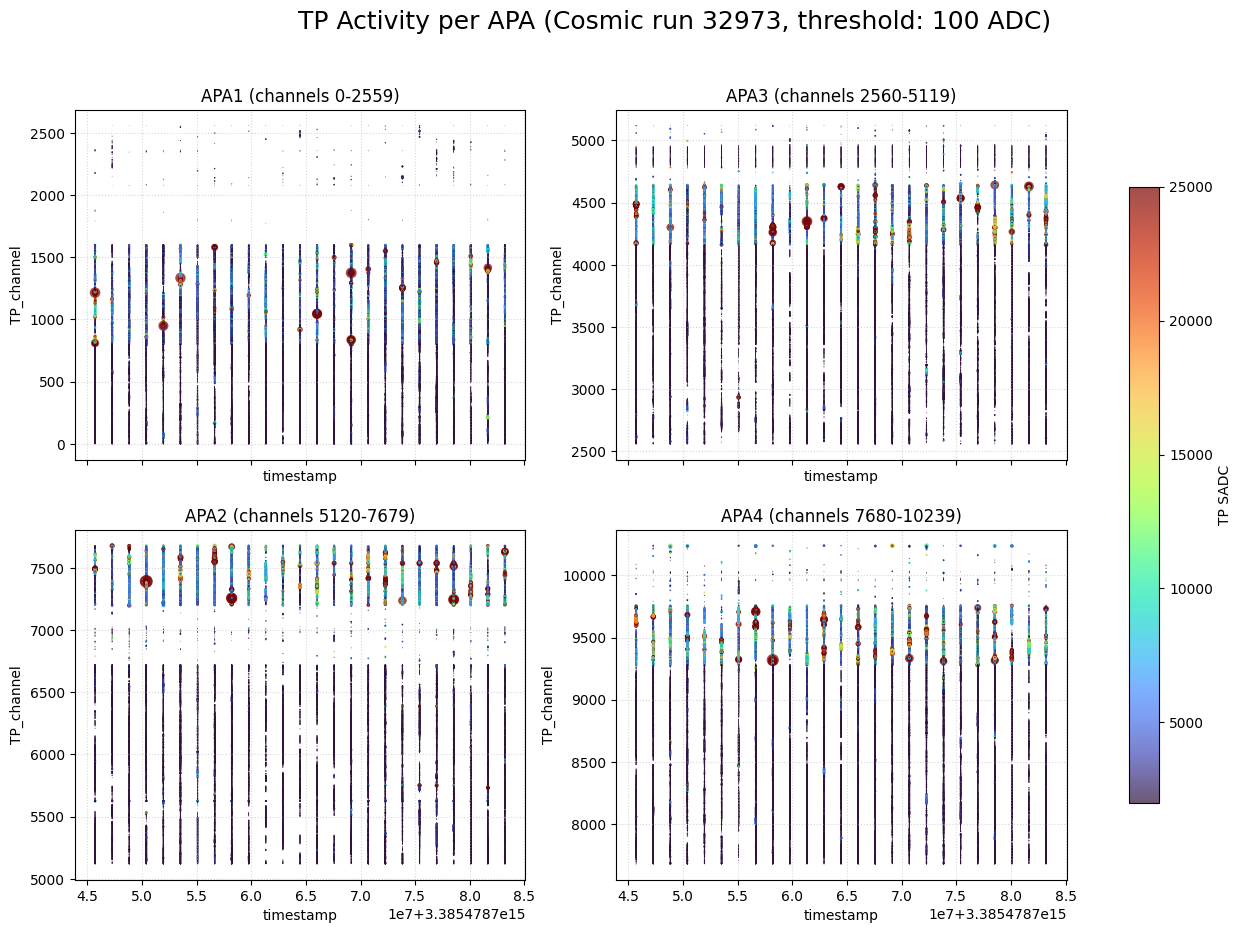

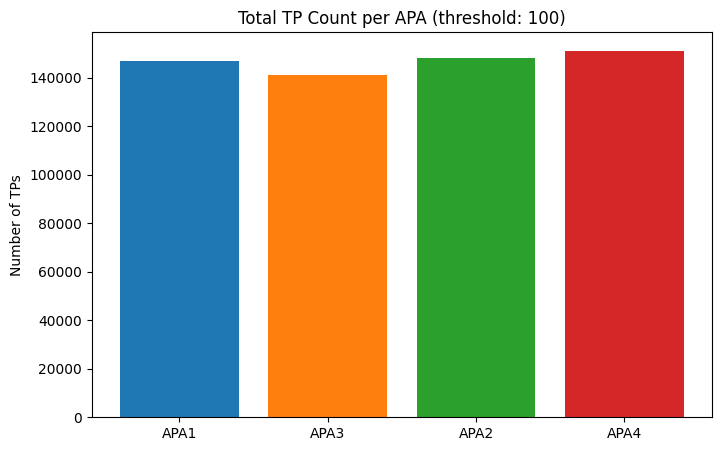

Run 32974
Threshold: 100 (TPs: 970319, Retaining 71.12% of raw TP)


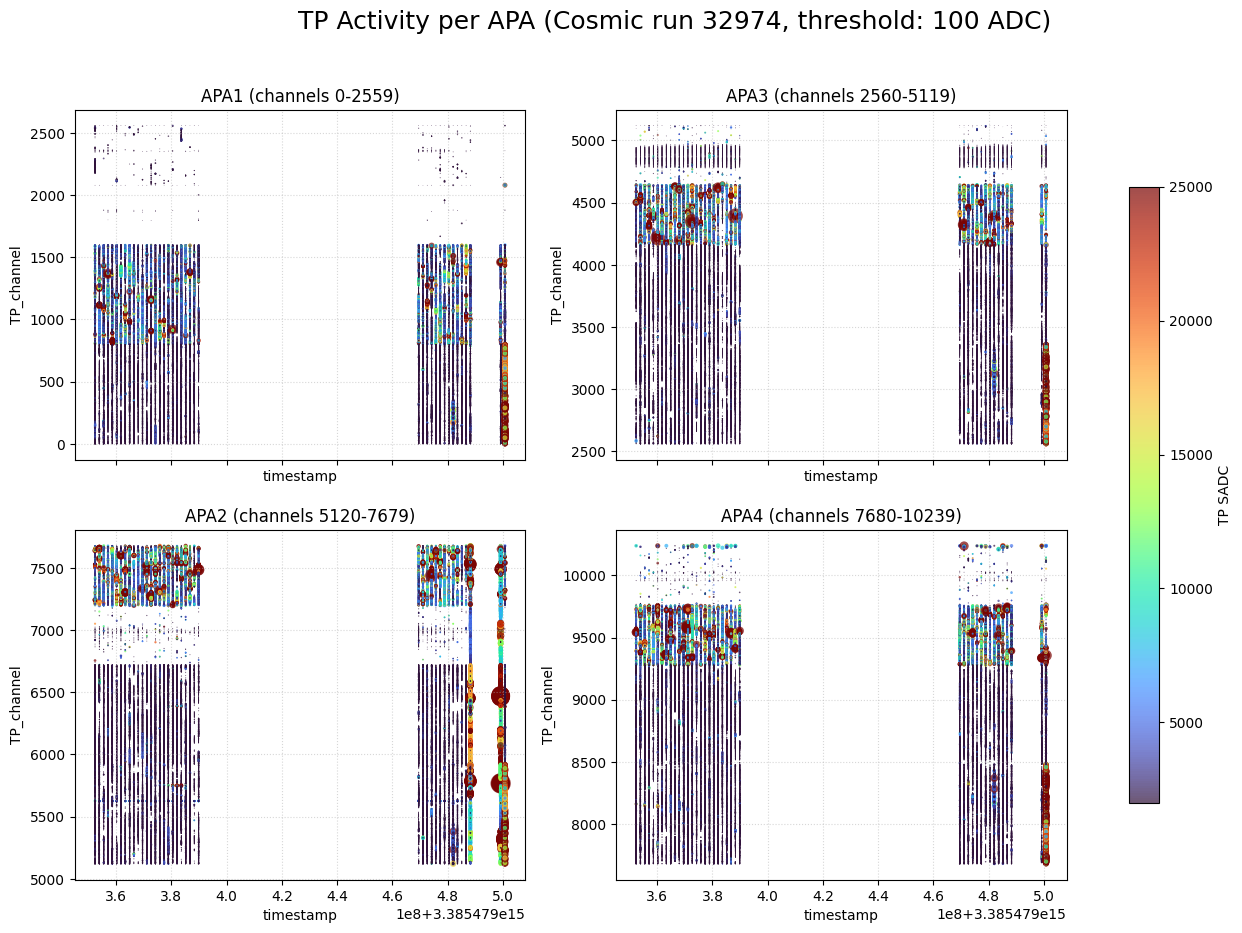

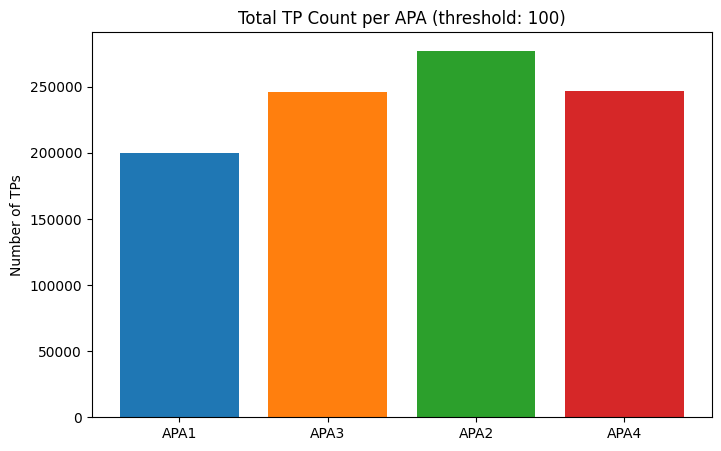

Run 32975
Threshold: 100 (TPs: 768923, Retaining 74.31% of raw TP)


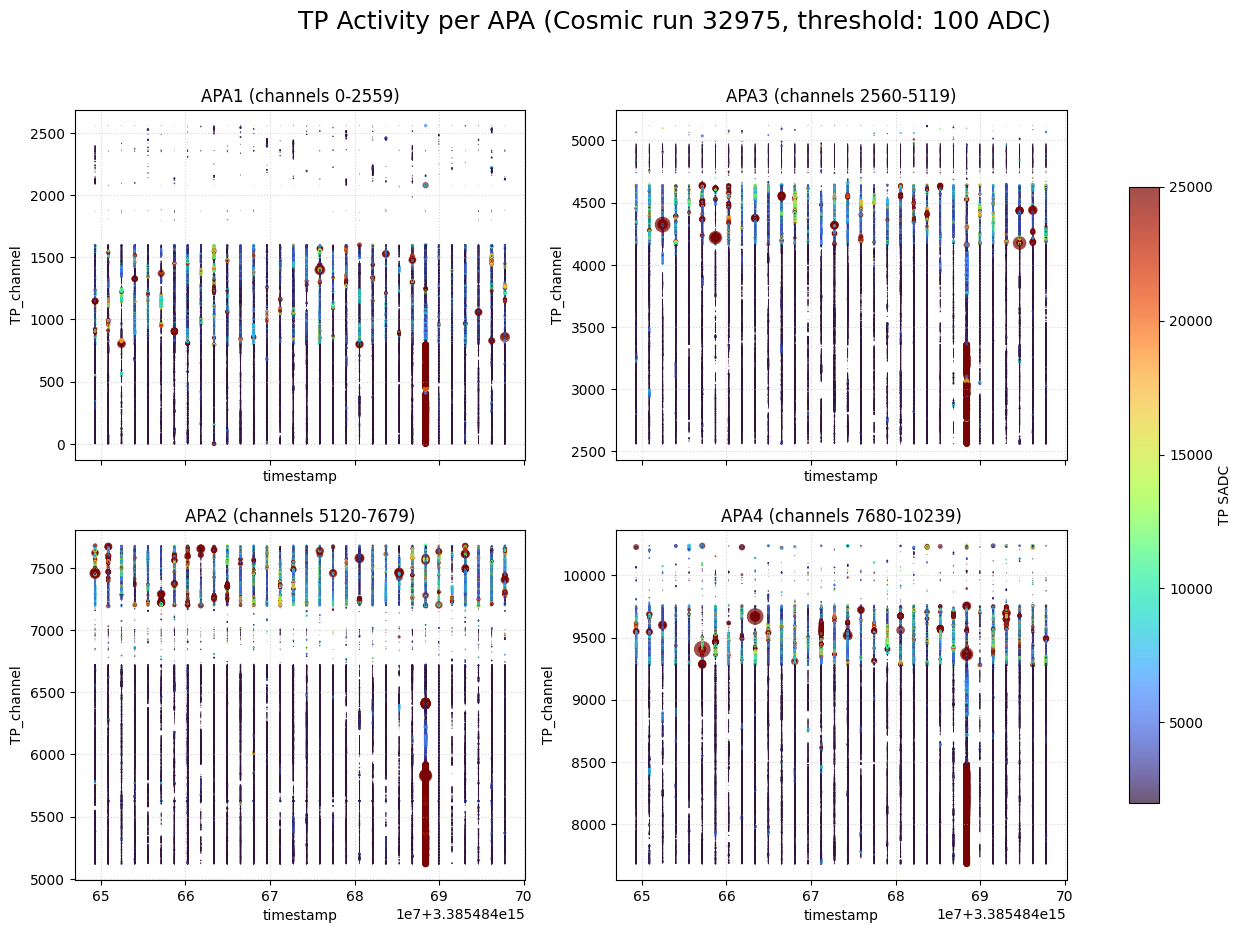

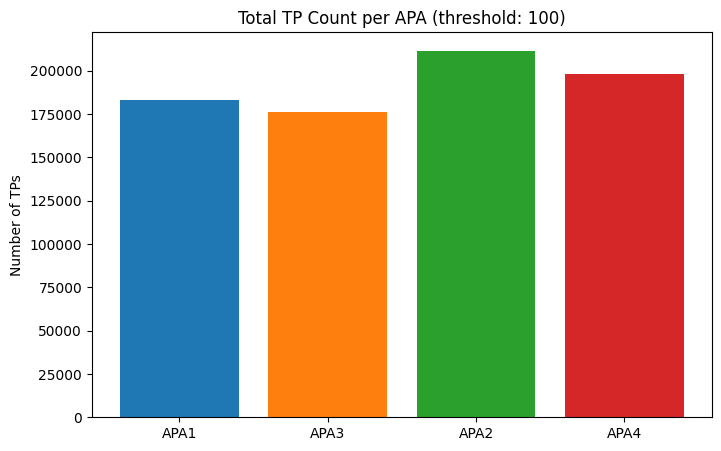

In [62]:
print("Run 32973")
plot_TPC_activity(df_32973, thresh=100, vmin=2000, vmax= 25000)

print("Run 32974")
plot_TPC_activity(df_32974, thresh=100, vmin=2000, vmax=25000)

print("Run 32975")
plot_TPC_activity(df_32975, thresh=100, vmin=2000, vmax=25000)

- The vertical lines correspond to clusters of triggered wires ("channels") that all saw charge arrive at the same time, as caused by a particle crossing the detector and producing simultaneous hits on many wires. 

    In MC: longer drift times, less channel variation

    DIfferent TP_SADC values across different channels: energy loss or geometry effect?

- There is clearly a "time gap" between hits, meaning that the registration of the event is not continous. Timestamps extremely vary between runs. 

- There also gaps on the y axis (channels) meaning there probably is a problem of dead channels that varies from run to run.

- APA2 is consistently noisier as in the MC

### Noise analysis and threshold finder

In [105]:
def find_optimal_TPC_threshold_noise_std(tps, n_sigma=3):
    """
    Calculate the noise threshold as the value of TP_peakADC corresponding to n_sigma standard deviations above the mean of the noise sample.
    """
    noise_cutoff = np.percentile(tps.TP_peakADC, 25)
    noise_sample = tps.TP_peakADC[tps.TP_peakADC < noise_cutoff]
    mu, sigma = np.mean(noise_sample), np.std(noise_sample)
    optimal_thresh = mu + n_sigma * sigma
    return optimal_thresh

def compare_TPC_threshold_algorithms(tps, plot=True): 
    """Compare different thresholding methods.
    Visualize on the TP_peakADC distribution, if plot is True (default)."""

    bins = int(np.sqrt(len(tps)) * 2)
    thresh_std_3s = find_optimal_TPC_threshold_noise_std(tps, n_sigma=3)
    thresh_std_5s = find_optimal_TPC_threshold_noise_std(tps, n_sigma=5)

    # Print results
    if plot:
        print("Threshold results:")
        print(f"  Noise std (mean+3sigma): {thresh_std_3s:.1f}")
        print(f"  Noise std (mean+5sigma): {thresh_std_5s:.1f}")

    if plot:
        hist, bin_edges = np.histogram(tps.TP_peakADC, bins=bins)
        plt.figure(figsize=(8,5))
        plt.bar(bin_edges[:-1], hist, width=bin_edges[1]-bin_edges[0], align='edge', color='gray', alpha=0.5)
        plt.axvline(thresh_std_3s, color='green', linestyle='-.', linewidth=2, label=f'Mean+3σ: {thresh_std_3s:.1f}')
        plt.axvline(thresh_std_5s, color='blue', linestyle='--', linewidth=2, label=f'Mean+5σ: {thresh_std_5s:.1f}')
        plt.xlim(0, 2000)
        plt.xlabel('TP_peakADC')
        plt.ylabel('Counts')
        plt.title('Comparison of TPC Thresholds')
        plt.legend()
        plt.xlim(0,100)
        plt.show()

        # TP retention summary
        total = len(tps)
        retained = {}
        for name, thresh in zip(['Mean+3σ'], [thresh_std_3s]):
            count = (tps.TP_peakADC > thresh).sum()
            percent = 100 * count / total
            retained[name] = percent
            print(f"Fraction of TPs retained by {name}: {percent:.2f}%")

    return  thresh_std_3s

Threshold results:
  Noise std (mean+3sigma): 116.4
  Noise std (mean+5sigma): 140.6


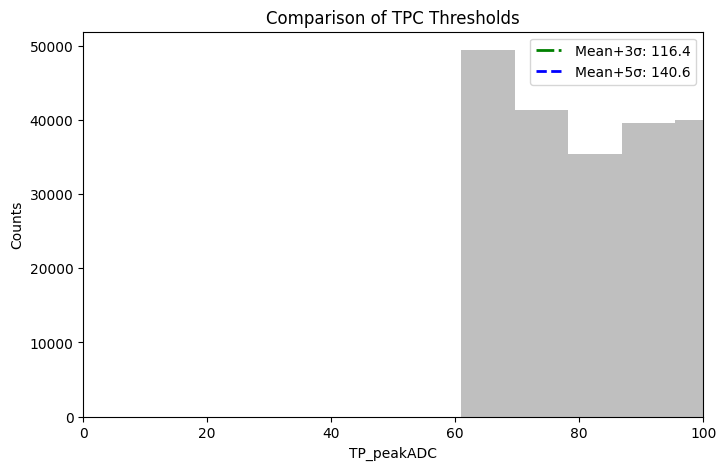

Fraction of TPs retained by Mean+3σ: 66.56%


In [106]:
results=compare_TPC_threshold_algorithms(df_32973)

### Pileup and dead channels analysis

In [ ]:
def quantify_TPC_pileup_APA(tps, time_window_us=10000):
    """
    Quantifies pileup (TPs per time window) separately for each APA.
    Returns a dict {APA_name: (counts_per_window, pileup_stats)}
    """
    global apa_ranges
    apa_pileup = {}
    for apa, (start, stop) in apa_ranges.items():
        df_apa = tps[(tps.TP_channel >= start) & (tps.TP_channel < stop)]
        if df_apa.empty:
            apa_pileup[apa] = (np.array([]), {
                'mean_TPs_per_window': 0,
                'std_TPs_per_window': 0,
                'pileups': 0,
                'total_windows': 0,
                'pile up percentage': 0
            })
            continue
        tmin, tmax = df_apa.TP_peakT.min(), df_apa.TP_peakT.max()
        # Ensure at least one bin, otherwise np.histogram will error on empty bins
        if tmin == tmax:
            bins = np.array([tmin, tmin + time_window_us])
        else:
            bins = np.arange(tmin, tmax + time_window_us, time_window_us)
        counts, _ = np.histogram(df_apa.TP_peakT, bins=bins)
        mean_counts = float(np.mean(counts)) if len(counts) > 0 else 0
        std_counts = float(np.std(counts)) if len(counts) > 0 else 0
        pileup_threshold = mean_counts + 3 * std_counts
        pileups = int((counts > pileup_threshold).sum())
        pileup_percentage = (pileups / len(counts) * 100) if len(counts) > 0 else 0
        pileup_stats = {
            'mean_TPs_per_window': mean_counts,
            'std_TPs_per_window': std_counts,
            'pileups': pileups,
            'total_windows': len(counts),
            'pile up percentage': pileup_percentage
        }
        apa_pileup[apa] = (counts, pileup_stats)
    return apa_pileup

def quantify_visible_energy_APA(tps, time_window_us=10000, adc_tick_to_mev=0.039):
    """
    Computes the visible energy (sum of TP_SADC × conversion) per time window for each APA.
    Returns a dict {APA_name: (energy_per_window, energy_stats)}
    """
    global apa_ranges

    apa_energy = {}
    for apa, (start, stop) in apa_ranges.items():
        df_apa = tps[(tps.TP_channel >= start) & (tps.TP_channel < stop)]
        if df_apa.empty:
            apa_energy[apa] = (np.array([]), {'mean_E_per_window_MeV': 0, 'max_E_per_window_MeV': 0})
            continue
        tmin, tmax = df_apa.TP_peakT.min(), df_apa.TP_peakT.max()
        bins = np.arange(tmin, tmax + time_window_us, time_window_us)
        df_apa = df_apa.copy()
        df_apa["time_bin"] = np.digitize(df_apa.TP_peakT, bins) - 1
        energy_per_bin = df_apa.groupby('time_bin')['TP_SADC'].sum().reindex(range(len(bins)-1), fill_value=0)
        energy_per_bin_MeV = energy_per_bin.values * adc_tick_to_mev
        energy_stats = {
            'mean_E_per_window_MeV': np.mean(energy_per_bin_MeV),
            'max_E_per_window_MeV': np.max(energy_per_bin_MeV)
        }
        apa_energy[apa] = (energy_per_bin_MeV, energy_stats)
    return apa_energy


def plot_visible_energy_per_APA(apa_energy, bins=80, title_suffix=""):
    for apa, (energy_per_window, _) in apa_energy.items():
        if len(energy_per_window) == 0:
            continue
        # Rimuove outlier estremi per la visualizzazione
        max_plot_energy = np.quantile(energy_per_window, 0.999)
        plot_energies = energy_per_window[energy_per_window <= max_plot_energy]

        plt.figure(figsize=(10, 6))
        plt.hist(plot_energies, bins=bins, color='gray', alpha=0.7, edgecolor='black', label="Vis. energy per window")
        # Evidenzia le zone
        plt.axvspan(0, 5, color='blue', alpha=0.12, label='Below 5 MeV')
        plt.axvspan(5, 20, color='orange', alpha=0.15, label='5-20 MeV')
        plt.axvspan(20, plot_energies.max()+1, color='red', alpha=0.10, label='Above 20 MeV')
        plt.xlabel("Visible energy per window [MeV]", fontsize=14)
        plt.ylabel("Number of windows", fontsize=14)
        plt.title(f"{apa} - Visible energy per window {title_suffix}", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
def extract_dead_TPC_channels(tps, expected_channel_range):
    """
    Returns a list of dead channels, i.e., channels in expected_channel_range that have zero TPs.
    expected_channel_range: iterable of all possible channel numbers (e.g., range(0, 10240))
    """
    active_channels = set(tps.TP_channel.unique())
    all_channels = set(expected_channel_range)
    dead_channels = sorted(all_channels - active_channels)
    print(f"Number of dead channels: {len(dead_channels)}")
    return dead_channels

In [103]:
def batch_TPC_analysis(run_data_list, vmin_list, vmax_list, adc_tick_to_mev=0.039):
    """
    Esegue plot, pileup e dead channel extraction per una lista di run.
    Esegue pileup (per finestra temporale) e energia visibile per APA.
    Inoltre, visualizza la distribuzione dell'energia visibile per finestra,
    evidenziando le regioni <5 MeV, 5-20 MeV, >20 MeV.
    """
    channel_range = range(0, 10240)
    for i, (df, vmin, vmax) in enumerate(zip(run_data_list, vmin_list, vmax_list)):
        run_name = getattr(df, "run_name", f"Run {i}")
        print(f"\n--- {run_name} ---")
        # Trova la soglia ottimale TP_peakADC
        threshold = compare_TPC_threshold_algorithms(df, False)
        df_thr = df[df.TP_peakADC > threshold].copy()
        df_thr.run_name = run_name

        # Plot TPC activity (scatter + bar plot of activity per APA)
        plot_TPC_activity(df_thr, threshold, vmin=vmin, vmax=vmax, show_counts=True)

        # Pileup per APA (easy method)
        print("\nPileup per APA (TPs per time window):")
        pileup_results = quantify_TPC_pileup_APA(df_thr)
        for apa, (counts, stats) in pileup_results.items():
            print(f"  {apa}: mean={stats['mean_TPs_per_window']:.2f}, pileup%={stats['pile up percentage']:.2f}%")

        # Visible energy per APA
        print("\nVisible energy per APA (MeV per time window):")
        energy_results = quantify_visible_energy_APA(df_thr, adc_tick_to_mev=adc_tick_to_mev)
        for apa, (energies, estats) in energy_results.items():
            print(f"  {apa}: mean={estats['mean_E_per_window_MeV']:.2f} MeV")

        # Dead channels
        print("\nDead channel info:")
        dead = extract_dead_TPC_channels(df_thr, channel_range)
        print(f"Dead channels percentage over all channels: {len(dead) / len(channel_range) * 100:.2f}%\n")

        # Plot visible energy distribution by window
        plot_visible_energy_distribution(energy_results,  df_thr.run_name )


--- Cosmic run 32973 ---
Threshold: 116.40744852244767 (TPs: 516001, Retaining 100.00% of raw TP)


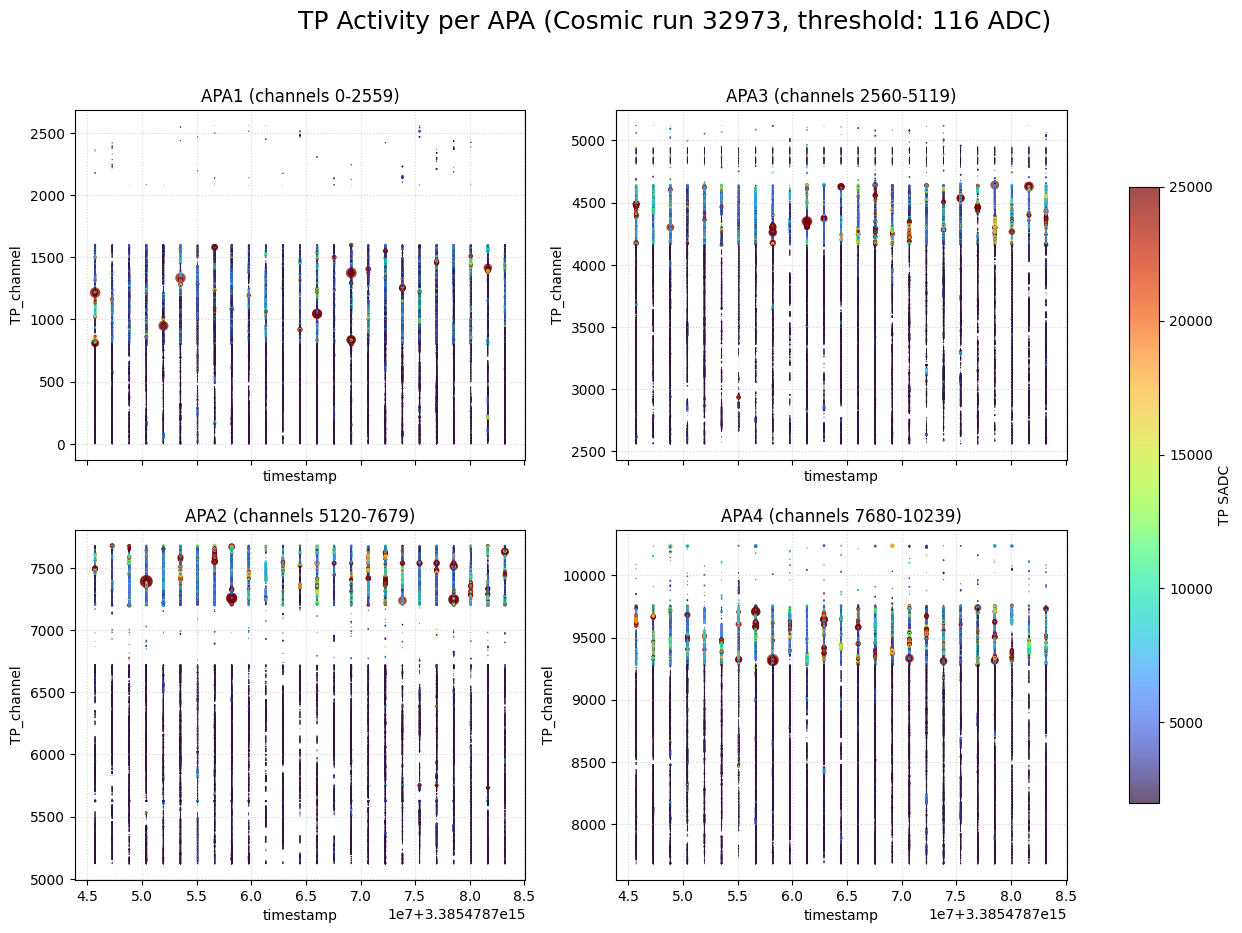

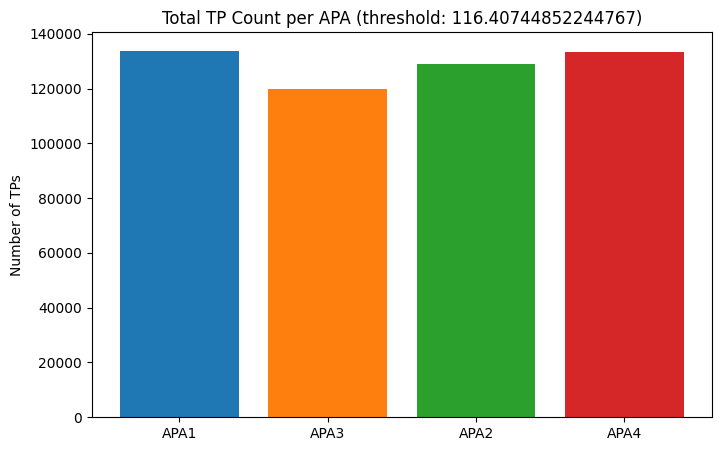


Pileup per APA (TPs per time window):
  APA1: mean=35.69, pileup%=0.83%
  APA3: mean=31.92, pileup%=0.88%
  APA2: mean=34.38, pileup%=0.80%
  APA4: mean=35.57, pileup%=0.80%

Visible energy per APA (MeV per time window):
  APA1: mean=3129.68 MeV
  APA3: mean=3366.44 MeV
  APA2: mean=3584.83 MeV
  APA4: mean=3796.54 MeV

Dead channel info:
Number of dead channels: 1322
Dead channels percentage over all channels: 12.91%



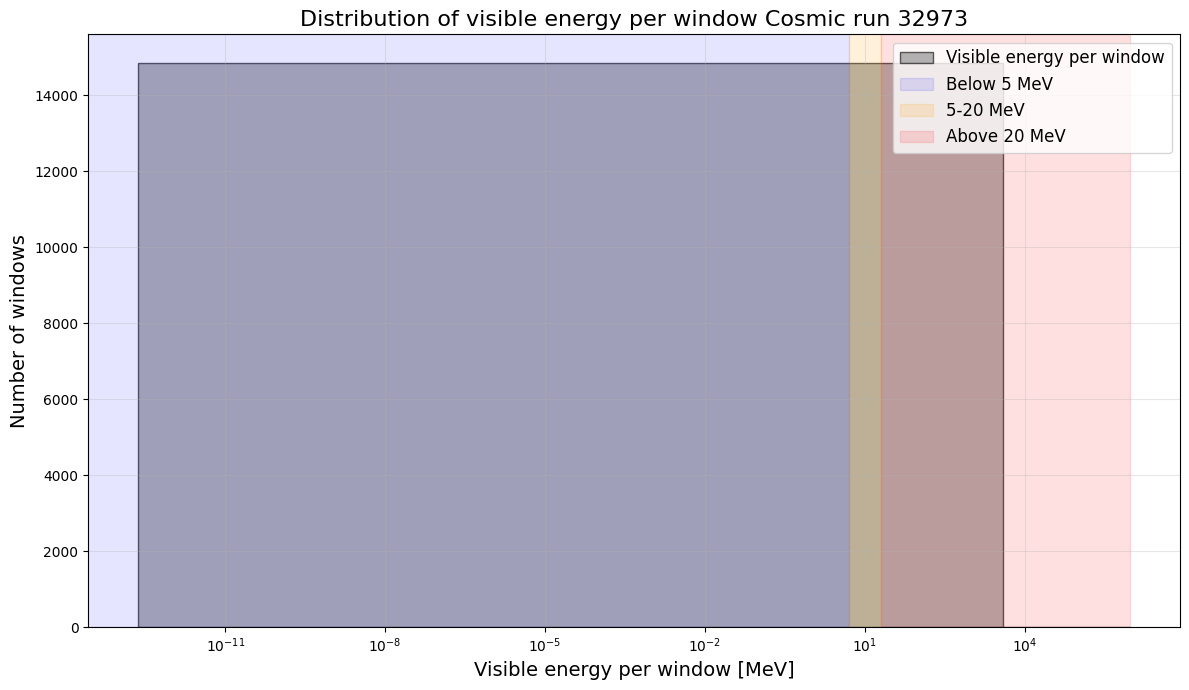


--- Cosmic run 32974 ---
Threshold: 104.18330286353046 (TPs: 937748, Retaining 100.00% of raw TP)


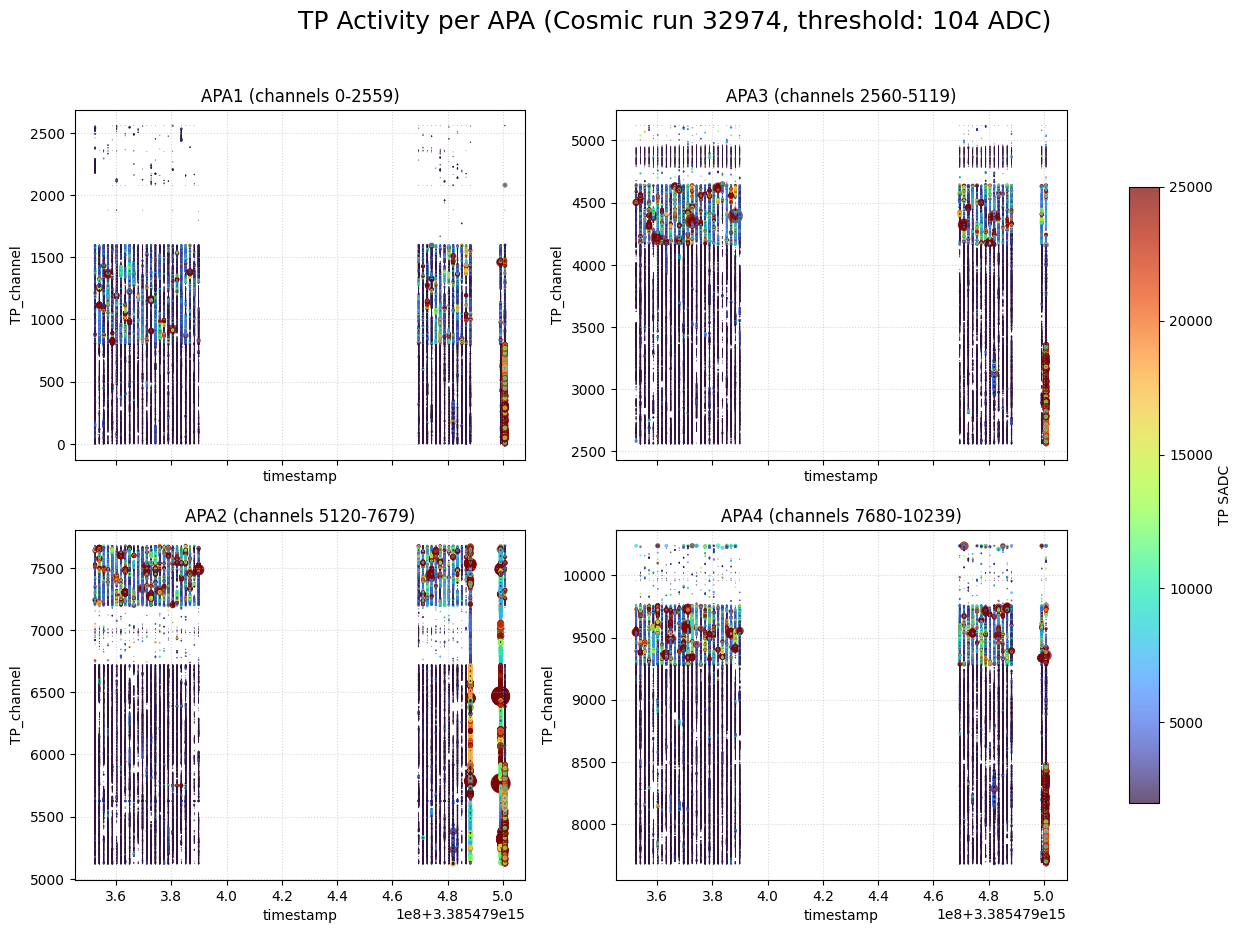

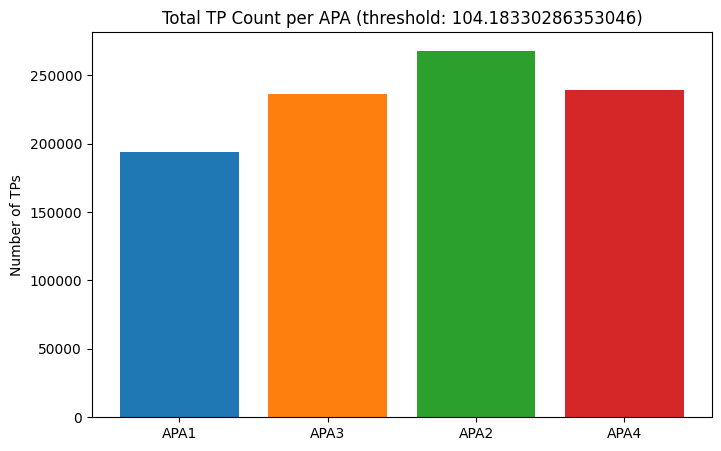


Pileup per APA (TPs per time window):
  APA1: mean=13.07, pileup%=0.34%
  APA3: mean=15.94, pileup%=0.37%
  APA2: mean=18.05, pileup%=0.36%
  APA4: mean=16.12, pileup%=0.36%

Visible energy per APA (MeV per time window):
  APA1: mean=1163.81 MeV
  APA3: mean=1495.70 MeV
  APA2: mean=2326.73 MeV
  APA4: mean=1608.77 MeV

Dead channel info:
Number of dead channels: 775
Dead channels percentage over all channels: 7.57%



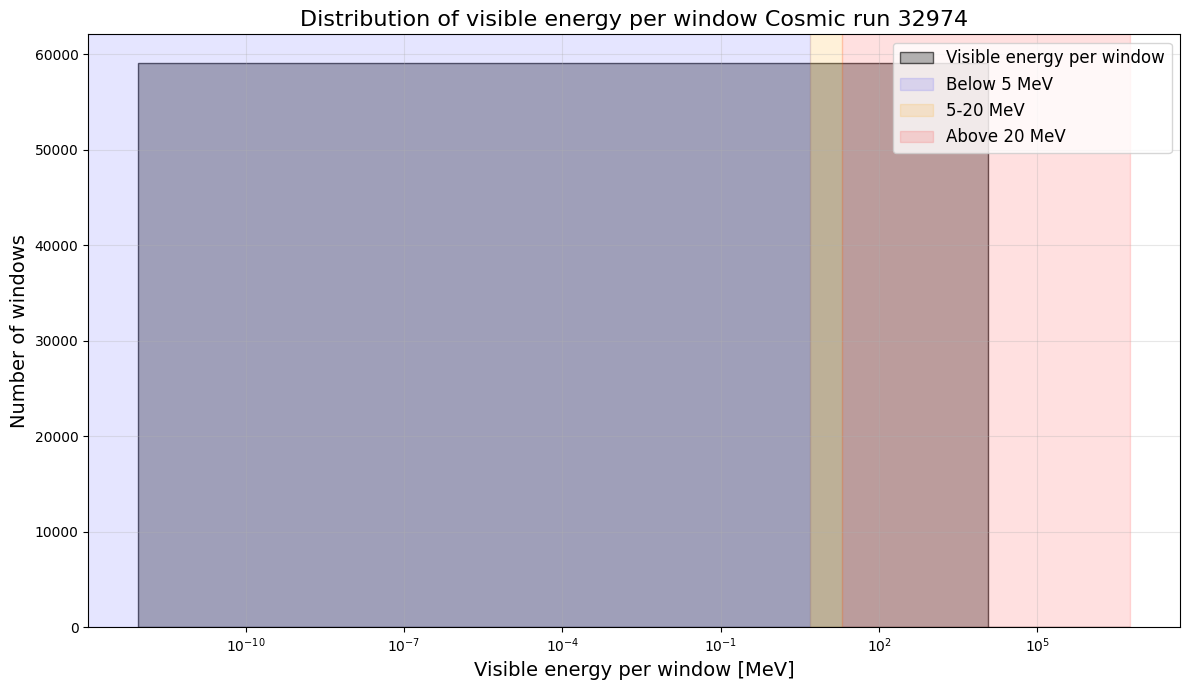


--- Cosmic run 32975 ---
Threshold: 112.2695591043781 (TPs: 696157, Retaining 100.00% of raw TP)


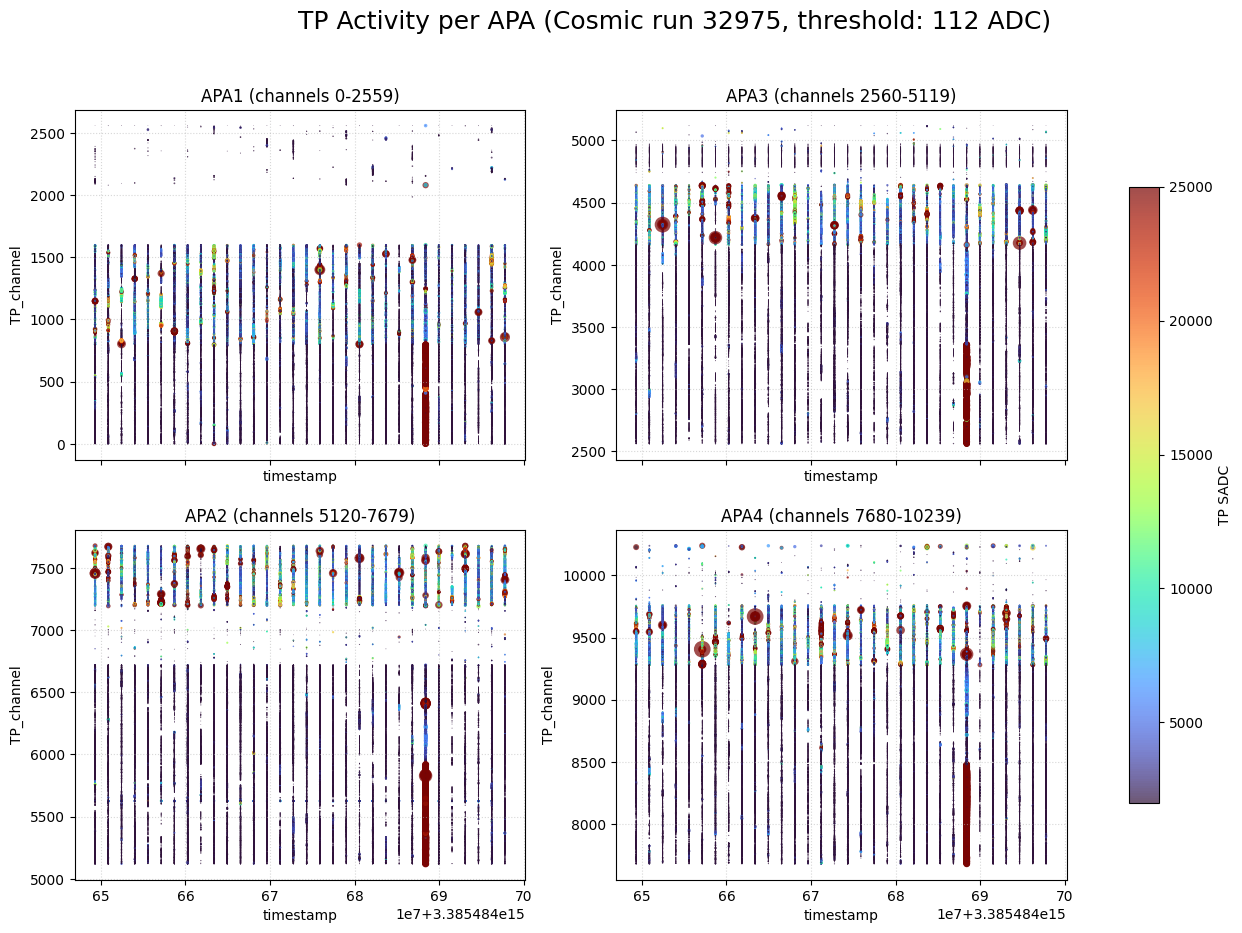

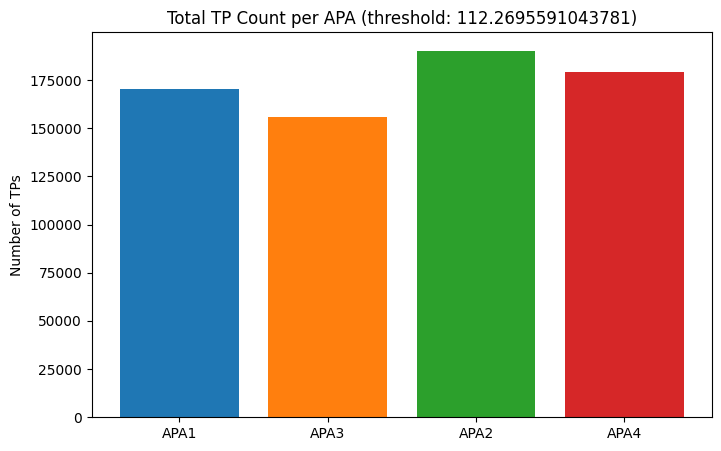


Pileup per APA (TPs per time window):
  APA1: mean=35.17, pileup%=0.78%
  APA3: mean=32.22, pileup%=0.80%
  APA2: mean=39.28, pileup%=0.78%
  APA4: mean=37.02, pileup%=0.74%

Visible energy per APA (MeV per time window):
  APA1: mean=3436.49 MeV
  APA3: mean=3378.09 MeV
  APA2: mean=4197.10 MeV
  APA4: mean=4190.65 MeV

Dead channel info:
Number of dead channels: 1035
Dead channels percentage over all channels: 10.11%



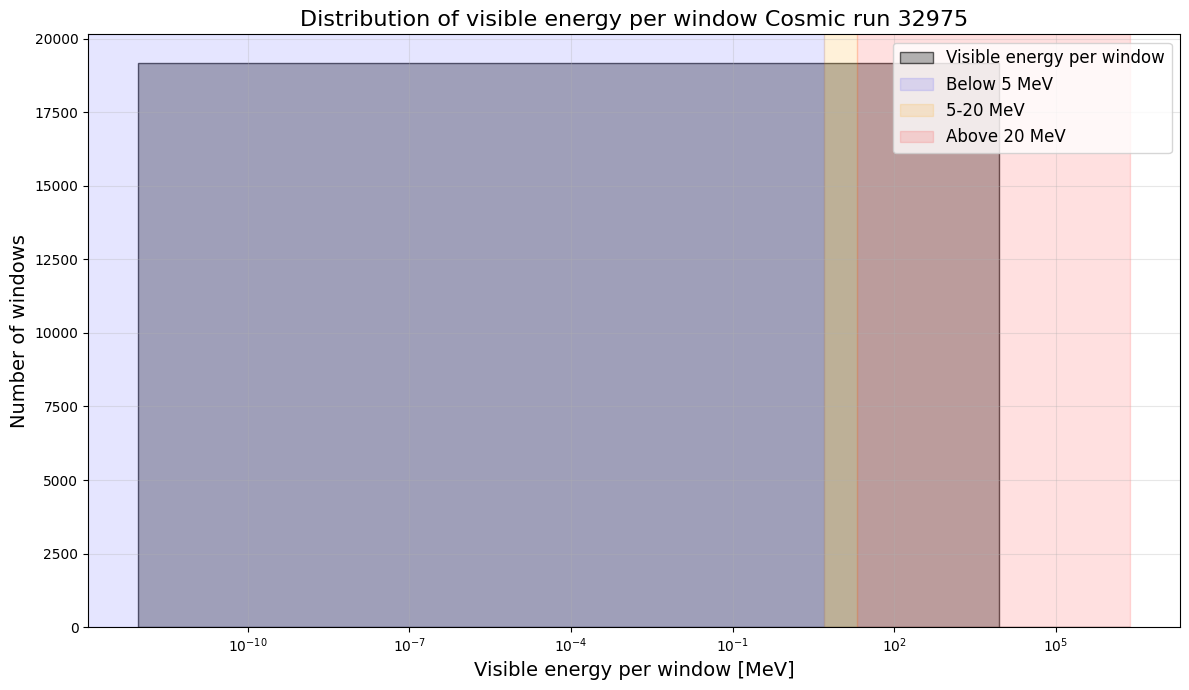

In [104]:
run_data_list = [df_32973, df_32974, df_32975]
vmin_list = [2000, 2000, 2000]
vmax_list = [25000, 25000, 25000]

batch_TPC_analysis(run_data_list, vmin_list, vmax_list)

###  event complexity, and signal features.